<a href="https://colab.research.google.com/github/jdmartinev/MachineLearning/blob/main/Talleres/1_Regresi%C3%B3n_con_RF_y_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1: Regresión con Random Forest y Gradient Boosting


En este taller se aplicará ensambes de árboles de decisión tipo random forest y gradient boosting a un conjunto de datos de jugadores del video juego FIFA 19. Los datos utilizados son un subconjunto modificado de [este set de datos](https://www.kaggle.com/karangadiya/fifa19) y se encuentran en el archivo `FIFA 19 players.csv`. La tarea a realizar consiste en predecir el salario (wage) de los jugadores.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    # BinaryEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [2]:
#Obtenemos los datos
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE' -O players.csv

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
id: ‘=1YkEYndYcq8Lhtx6KnGFBjUGguaP6wVwE -O players.csv’: no such user


In [3]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [4]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [5]:
# Carguemos los datos:
data = pd.read_csv('./datasets/players.csv')
data.head()

,Name,Age,Overall,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,L. Messi,31,94,565000,Left,5.0,4.0,4.0,90.0,90.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,Cristiano Ronaldo,33,94,405000,Right,5.0,4.0,5.0,94.0,94.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,Neymar Jr,26,92,290000,Right,5.0,5.0,5.0,87.0,87.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,K. De Bruyne,27,91,355000,Right,4.0,5.0,4.0,85.0,85.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,E. Hazard,27,91,340000,Right,4.0,4.0,4.0,86.0,86.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0


In [6]:
# Veamos la descripción del dataset:
### CÓDIGO AQUÍ ###
data.describe()


,Age,Overall,Wage,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,...,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.000000,15926.00000,15926.000000,15926.000000,15926.000000
mean,24.991209,66.446189,10254.866256,1.116037,3.004081,2.533342,59.842647,59.842647,59.842647,61.066809,...,51.446126,59.575411,50.401168,54.844405,55.494726,52.118234,60.34654,51.273703,51.883021,49.593118
std,4.552866,6.809244,22692.769542,0.397762,0.636845,0.618186,9.141407,9.141407,9.141407,9.889102,...,15.718376,14.432944,18.797738,14.665434,12.897478,12.501841,10.14202,17.198926,19.161875,19.162508
min,16.000000,46.000000,1000.000000,1.000000,1.000000,2.000000,33.000000,33.000000,33.000000,27.000000,...,11.000000,13.000000,10.000000,11.000000,12.000000,12.000000,29.00000,10.000000,10.000000,10.000000
25%,21.000000,62.000000,1000.000000,1.000000,3.000000,2.000000,54.000000,54.000000,54.000000,55.000000,...,40.000000,50.000000,34.000000,46.000000,47.000000,42.000000,53.00000,37.000000,35.000000,32.000000
50%,25.000000,66.000000,3000.000000,1.000000,3.000000,2.000000,60.000000,60.000000,60.000000,62.000000,...,54.000000,61.000000,56.000000,57.000000,57.000000,52.000000,61.00000,56.000000,59.000000,56.000000
75%,28.000000,71.000000,10000.000000,1.000000,3.000000,3.000000,66.000000,66.000000,66.000000,68.000000,...,64.000000,70.000000,65.000000,65.000000,65.000000,61.000000,68.00000,65.000000,67.000000,65.000000
max,41.000000,94.000000,565000.000000,5.000000,5.000000,5.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.00000,94.000000,93.000000,91.000000


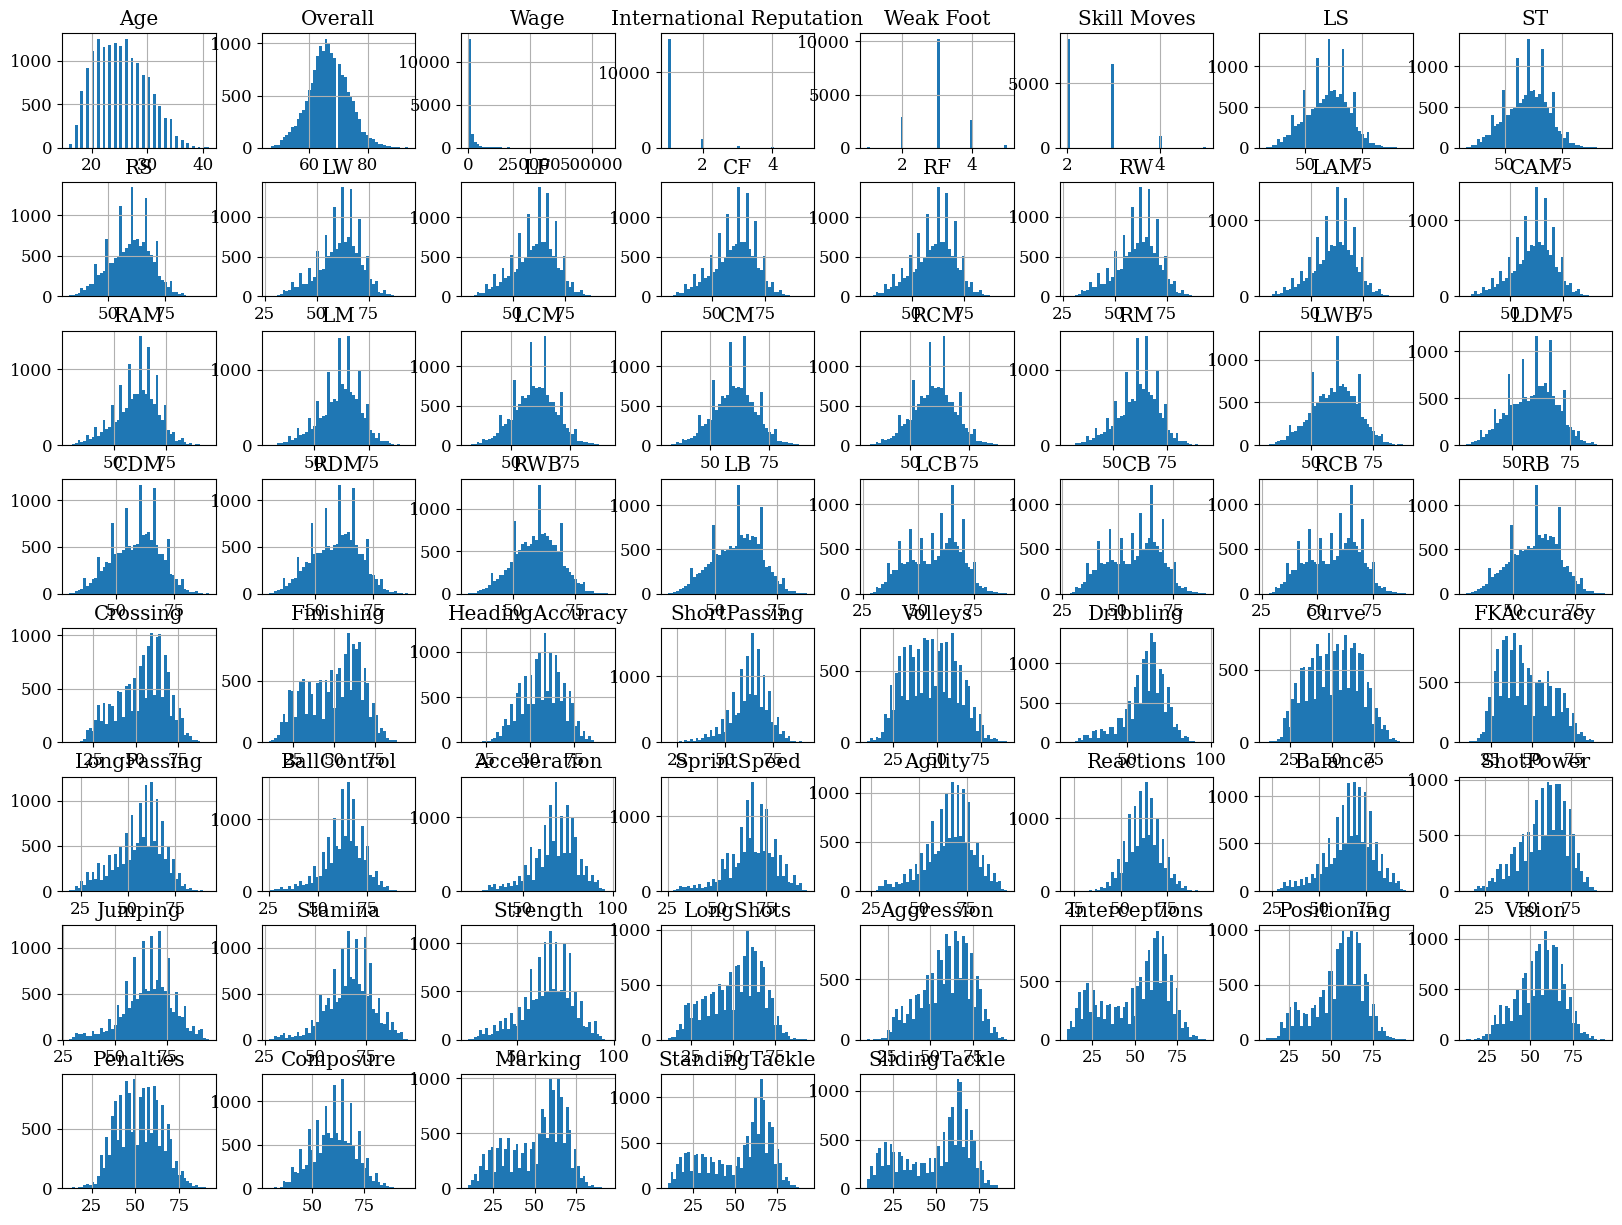

In [7]:
#Veamos la distribución de las columnas
### CÓDIGO AQUÍ ###
data.hist(bins=50, figsize=(20,15))
plt.title('Distribución de las columnas')
plt.show()

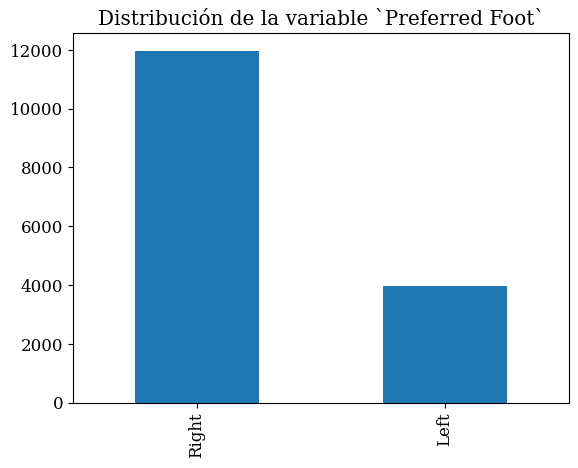

In [8]:
# Obtengamos la distribución de valores de la variable `Preferred Foot`:
# tip: pandas function value_counts()
### CÓDIGO AQUÍ ###
data['Preferred Foot'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable `Preferred Foot`')
plt.show()


In [9]:
# Dado que esta columna es categorica, debemos incluir en el Pipeline su transformación. Utilizaremos
# codificación binaria
#tip: scikit-learn BinaryEncoder -> Igual funcionamiento a OrdinalEncoder

## Regresión

**Nota:** Dejaremos la coulmna `Name` en el datafrme para poder identificar a los jugadores, pero **la debemos excluir** al definir las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test`.

In [12]:
# Separemos los datos en conjuntos de entrenamiento (80 %) y prueba (20 %):
### CÓDIGO AQUÍ ###
y =  data['Wage']
X = data.drop(['Wage', 'Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [20]:
#Definimos las transformaciones
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

categorical_transformer = OrdinalEncoder()
numerical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

#Definimos los pipelines
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', rf_base)])
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', gb_base)])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10, 15],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [21]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

c:\Users\Juan M\Maestria\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Juan M\Maestria\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Juan M\Maestria\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Juan M\Maestria\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_

CPU times: total: 3h 17min 19s
Wall time: 3h 51min 53s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing'...
      dtype='object')),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         Index(['Preferred Foot'], dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [5, 10, 15, 20],
                         'regressor__max_features': ['auto', 'sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 5, 10],
                         'regressor__min_samples_split': [2, 5, 10, 15],
                         'regressor__n_estimators': [100, 200, 300]})

In [22]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
{'regressor__max_depth': 5, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 15, 'regressor__n_estimators': 100}


In [23]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.9208627376589055
MAE: 2970.5003538850156


Model: Gradient Boosting
R^2: 0.8986284889850961
MAE: 3813.328184266627


Test set
Model: Random Forest
R^2: 0.7928120090341031
MAE: 4796.809652791618


Model: Gradient Boosting
R^2: 0.8044681667169041
MAE: 4682.604838131884




In [39]:
# Veamos los datos junto con las predicciones:
pd.concat([
    data.drop(columns='Wage').reset_index(drop=True),
    data['Wage'].reset_index(drop=True),
    pd.DataFrame({'rf_predicted_wage': rf.predict(data.drop(columns=['Name', 'Wage']))}),
    pd.DataFrame({'gb_predicted_wage': gb.predict(data.drop(columns=['Name', 'Wage']))})
], axis=1)

,Name,Age,Overall,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Wage,rf_predicted_wage,gb_predicted_wage
0,L. Messi,31,94,Left,5.0,4.0,4.0,90.0,90.0,90.0,...,94.0,94.0,75.0,96.0,33.0,28.0,26.0,565000,328958.517316,358165.684644
1,Cristiano Ronaldo,33,94,Right,5.0,4.0,5.0,94.0,94.0,94.0,...,95.0,82.0,85.0,95.0,28.0,31.0,23.0,405000,355231.928692,405013.361375
2,Neymar Jr,26,92,Right,5.0,5.0,5.0,87.0,87.0,87.0,...,89.0,87.0,81.0,94.0,27.0,24.0,33.0,290000,313898.959476,295689.576469
3,K. De Bruyne,27,91,Right,4.0,5.0,4.0,85.0,85.0,85.0,...,87.0,94.0,79.0,88.0,68.0,58.0,51.0,355000,317983.900794,353732.957393
4,E. Hazard,27,91,Right,4.0,4.0,4.0,86.0,86.0,86.0,...,87.0,89.0,86.0,91.0,34.0,27.0,22.0,340000,315770.027297,331189.313380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15921,J. Lundstram,19,47,Right,1.0,2.0,2.0,44.0,44.0,44.0,...,39.0,52.0,43.0,45.0,40.0,48.0,47.0,1000,1186.692000,1634.341493
15922,N. Christoffersson,19,47,Right,1.0,2.0,2.0,47.0,47.0,47.0,...,46.0,33.0,43.0,42.0,22.0,15.0,19.0,1000,1227.487296,1656.086219
15923,B. Worman,16,47,Right,1.0,3.0,2.0,47.0,47.0,47.0,...,48.0,43.0,55.0,41.0,32.0,13.0,11.0,1000,1243.327548,1634.341493
15924,D. Walker-Rice,17,47,Right,1.0,3.0,2.0,49.0,49.0,49.0,...,44.0,47.0,50.0,46.0,20.0,25.0,27.0,1000,1214.062063,1634.341493


Explicabilidad

In [26]:
!pip install shap

   ---------------------------------------- 450.3/450.3 kB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 2.6/2.6 MB 33.5 MB/s eta 0:00:00
   ---------------------------------------- 28.1/28.1 MB 38.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import shap
from IPython.display import HTML

In [28]:
# Entrenamos nuestro pipeline con los mejores parámetros encontrados en la validación cruzada
pipeline_gb.set_params(**gb.best_params_)
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['Age', 'Overall', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
       'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPas...
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['Preferred Foot'], dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, max_features='log2',
                                           min_samples_leaf=2,
                                           min_samples_split=15,
                                           random_state=42))])

In [29]:
# Aplicamos el preproceso a los datos
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [30]:
# Entrenemos nuestro modelo de explicabilidad
gb_explainer = shap.Explainer(pipeline_gb.named_steps['regressor'])
train_gb_shap_values = gb_explainer.shap_values(X_train_preprocessed)

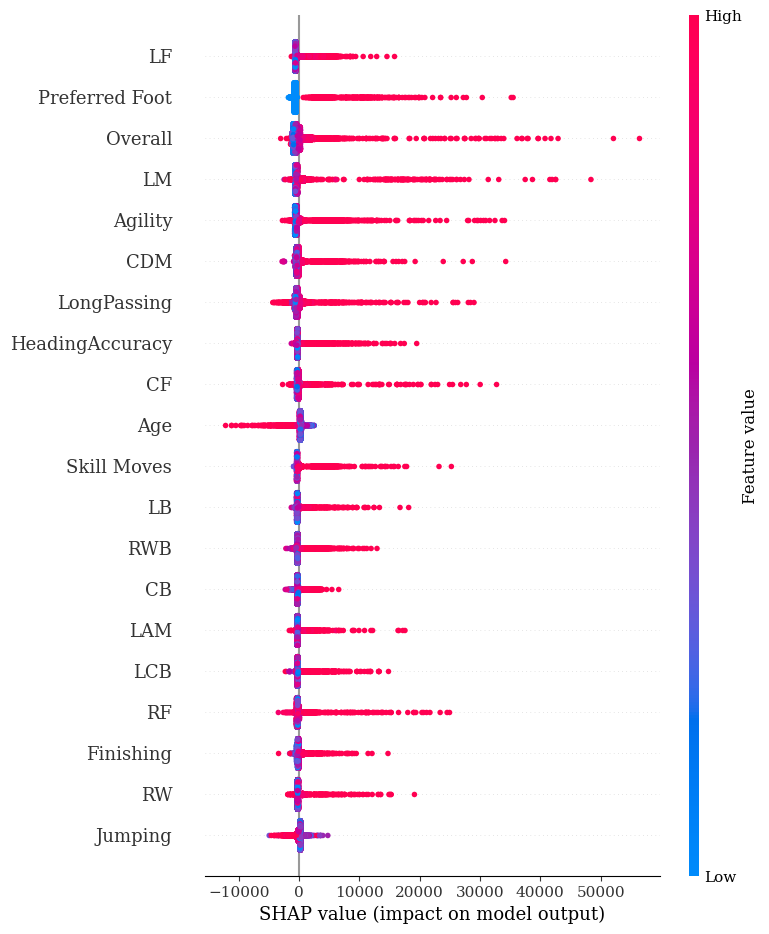

In [43]:
# Summary plot
### CÓDIGO AQUÍ ###
shap.summary_plot(train_gb_shap_values, X_train_preprocessed, feature_names=X_train.columns)

In [44]:
# Grafiquemos los valores SHAP para un ejemplo del conjunto de test
### CÓDIGO AQUÍ ###
shap.initjs()
instance_index = 0
force_plot_html = shap.force_plot(gb_explainer.expected_value, train_gb_shap_values[instance_index], X_train.iloc[instance_index], show=False)
HTML(force_plot_html.html())

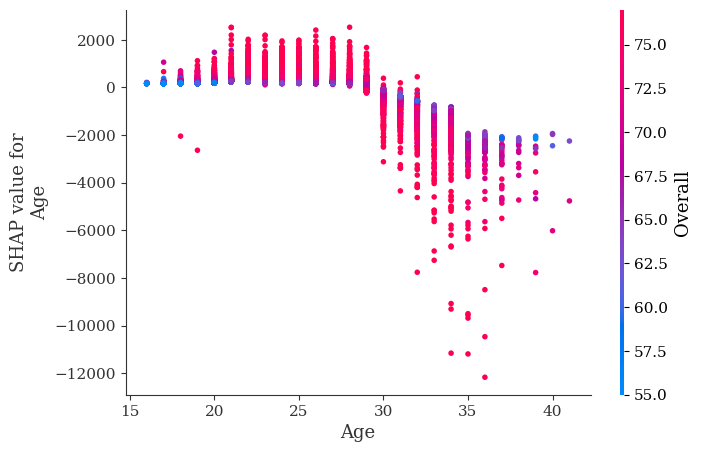

In [51]:
# Grafiquemos la dependencia de los valores SHAP con la variable "Age"
shap.dependence_plot('Age', train_gb_shap_values, X_train)